# **TPS - Oct 2021**

## **XGBoost & LightGBM & CatBoost Stacking**

### Thank you for visiting my notebook :)
### This notebook is for beginner like me **who wants to study stacking ensemble!**

#### **Stacking Ensemble** is a nice technique for forwarding you score.
#### As you can see below image, Stacking Ensemble needs some models for classification and meta-model for final prediction!

#### Here's what you need to do.
**Step1. Make your train, test data for training & prediction (Preprocessing)**

**Step2. Select some models for making stacking datasets!! (Train models and Making Datasets)**

**Step3. Select final model for meta-model!**

**Step4. With your meta-model, Train & Predict with stacking datasets ;)**

![Stacking Ensemble](http://rasbt.github.io/mlxtend/user_guide/classifier/StackingClassifier_files/stackingclassification_overview.png)

# **Import Library**

In [1]:
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

# **Load Data**

In [2]:
train = pd.read_csv('../input/tabular-playground-series-oct-2021/train.csv',nrows=10**5)
test = pd.read_csv('../input/tabular-playground-series-oct-2021/test.csv')

train.head()

,id,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f276,f277,f278,f279,f280,f281,f282,f283,f284,target
0,0,0.205979,0.410993,0.176775,0.223581,0.423543,0.476140,0.413590,0.612021,0.534873,...,0,1,0,0,0,0,0,0,0,1
1,1,0.181004,0.473119,0.011734,0.213657,0.619678,0.441593,0.230407,0.686013,0.281971,...,0,1,0,0,0,0,0,0,0,1
2,2,0.182583,0.307431,0.325950,0.207116,0.605699,0.309695,0.493337,0.751107,0.536272,...,0,0,0,1,1,0,0,0,0,1
3,3,0.180240,0.494592,0.008367,0.223580,0.760618,0.439211,0.432055,0.776147,0.483958,...,0,0,0,0,1,0,0,0,0,1
4,4,0.177172,0.495513,0.014263,0.548819,0.625396,0.562493,0.117158,0.561255,0.077115,...,0,1,1,0,1,0,0,1,0,1


In [3]:
def reduce_memory_usage(df, verbose=True):
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

In [4]:
train = reduce_memory_usage(train)
test = reduce_memory_usage(test)

Mem. usage decreased to 50.54 Mb (76.9% reduction)
Mem. usage decreased to 252.25 Mb (76.9% reduction)


## **Checking Missing Values**

In [ ]:
print(train.isna().sum(), test.isna().sum())

# Feature Generation

In [5]:
y = train['target']
train.drop(columns = ['id', 'target'], inplace = True)
test.drop(columns = 'id', inplace = True)

In [15]:
B_feature1 = ['f22', 'f43']+list(train.columns[243:286])#f22, f43, f242 ~ f284
B_feature2 = list(train.columns[242:286])#f22, f43, f242 ~ f284
B_feature3 = ['f22', 'f43']
# train[B_feature2].head()

## **エルボー法**

### **正規化なし**

In [7]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
def elbow_method(X):
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 10, n_init = 10, random_state = 10)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)
    
    plt.plot(range(1, 11), wcss)
    plt.title('The elbow method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS') 
    plt.show()
#     return wcss

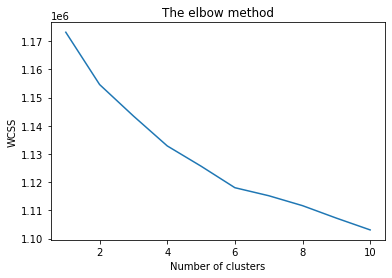

In [8]:
elbow_method(train)

### **正規化あり**

#### **標準化**

In [16]:
df = train[B_feature2].copy()
train_scaler = (df - df.mean()) / df.std(ddof=0)

In [20]:
train_scaler.head()

,f242,f243,f244,f245,f246,f247,f248,f249,f250,f251,...,f275,f276,f277,f278,f279,f280,f281,f282,f283,f284
0,1.433925,-0.529352,1.163993,0.737593,0.486272,-1.456934,-0.618647,-0.880842,-0.876893,-1.022759,...,-0.554077,-0.553738,2.425250,-0.421220,-0.379121,-0.408053,-0.483362,-0.410335,-0.445640,-0.418039
1,1.433925,-0.529352,-0.859111,-1.355761,0.486272,-1.456934,-0.618647,1.135277,-0.876893,0.977748,...,1.804802,-0.553738,2.425250,-0.421220,-0.379121,-0.408053,-0.483362,-0.410335,-0.445640,-0.418039
2,-0.697386,-0.529352,1.163993,0.737593,0.486272,0.686373,-0.618647,-0.880842,1.140390,-1.022759,...,-0.554077,-0.553738,-0.412329,-0.421220,2.637679,2.450662,-0.483362,-0.410335,-0.445640,-0.418039
3,1.433925,-0.529352,1.163993,0.737593,0.486272,0.686373,-0.618647,1.135277,1.140390,-1.022759,...,1.804802,-0.553738,-0.412329,-0.421220,-0.379121,2.450662,-0.483362,-0.410335,-0.445640,-0.418039
4,-0.697386,-0.529352,1.163993,0.737593,-2.056461,-1.456934,-0.618647,1.135277,1.140390,0.977748,...,-0.554077,-0.553738,2.425250,2.374056,-0.379121,2.450662,-0.483362,-0.410335,2.243962,-0.418039


In [21]:
train_scaler = pd.concat([train.drop(columns=B_feature2),train_scaler],axis=1)
train_scaler.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f275,f276,f277,f278,f279,f280,f281,f282,f283,f284
0,0.205933,0.410889,0.176758,0.223633,0.423584,0.476074,0.413574,0.611816,0.534668,0.147339,...,-0.554077,-0.553738,2.425250,-0.421220,-0.379121,-0.408053,-0.483362,-0.410335,-0.445640,-0.418039
1,0.181030,0.473145,0.011734,0.213623,0.619629,0.441650,0.230347,0.686035,0.281982,0.238525,...,1.804802,-0.553738,2.425250,-0.421220,-0.379121,-0.408053,-0.483362,-0.410335,-0.445640,-0.418039
2,0.182617,0.307373,0.325928,0.207153,0.605469,0.309814,0.493408,0.750977,0.536133,0.286865,...,-0.554077,-0.553738,-0.412329,-0.421220,2.637679,2.450662,-0.483362,-0.410335,-0.445640,-0.418039
3,0.180298,0.494629,0.008369,0.223633,0.760742,0.439209,0.432129,0.776367,0.483887,0.260986,...,1.804802,-0.553738,-0.412329,-0.421220,-0.379121,2.450662,-0.483362,-0.410335,-0.445640,-0.418039
4,0.177124,0.495605,0.014259,0.548828,0.625488,0.562500,0.117188,0.561035,0.077087,0.158325,...,-0.554077,-0.553738,2.425250,2.374056,-0.379121,2.450662,-0.483362,-0.410335,2.243962,-0.418039


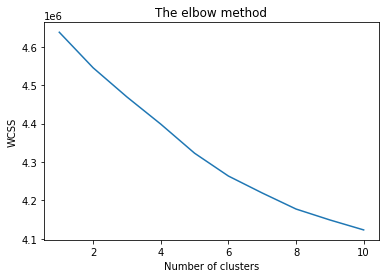

In [22]:
elbow_method(train_scaler)

#### **B_feature以外**

In [30]:
df = train.drop(columns=B_feature2).copy()

In [31]:
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f232,f233,f234,f235,f236,f237,f238,f239,f240,f241
0,0.205933,0.410889,0.176758,0.223633,0.423584,0.476074,0.413574,0.611816,0.534668,0.147339,...,0.195801,0.203491,0.036316,0.157715,0.199097,0.007442,0.189087,0.202515,0.273193,0.167236
1,0.181030,0.473145,0.011734,0.213623,0.619629,0.441650,0.230347,0.686035,0.281982,0.238525,...,0.195679,0.203735,0.083984,0.206299,0.249268,0.003757,0.269775,0.200684,0.166504,0.211182
2,0.182617,0.307373,0.325928,0.207153,0.605469,0.309814,0.493408,0.750977,0.536133,0.286865,...,0.195923,0.204346,0.142578,0.291504,0.205444,0.008804,0.125122,0.199463,0.196411,0.238281
3,0.180298,0.494629,0.008369,0.223633,0.760742,0.439209,0.432129,0.776367,0.483887,0.260986,...,0.196289,0.204224,0.031128,0.198486,0.280518,0.002342,0.125610,0.198853,0.171509,0.216064
4,0.177124,0.495605,0.014259,0.548828,0.625488,0.562500,0.117188,0.561035,0.077087,0.158325,...,0.194824,0.205688,0.174072,0.189941,0.165771,0.001957,0.169800,0.199097,0.141724,0.217407


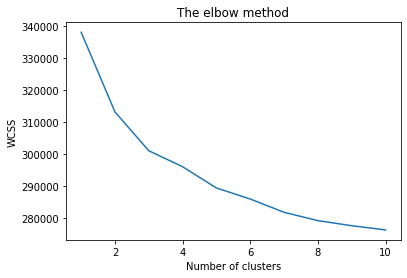

In [32]:
elbow_method(df)

#### **B_featureのみ**

**正規化あり(標準化）**

In [33]:
df = train[B_feature2].copy()
train_scaler = (df - df.mean()) / df.std(ddof=0)

In [34]:
train_scaler.head()

,f242,f243,f244,f245,f246,f247,f248,f249,f250,f251,...,f275,f276,f277,f278,f279,f280,f281,f282,f283,f284
0,1.433925,-0.529352,1.163993,0.737593,0.486272,-1.456934,-0.618647,-0.880842,-0.876893,-1.022759,...,-0.554077,-0.553738,2.425250,-0.421220,-0.379121,-0.408053,-0.483362,-0.410335,-0.445640,-0.418039
1,1.433925,-0.529352,-0.859111,-1.355761,0.486272,-1.456934,-0.618647,1.135277,-0.876893,0.977748,...,1.804802,-0.553738,2.425250,-0.421220,-0.379121,-0.408053,-0.483362,-0.410335,-0.445640,-0.418039
2,-0.697386,-0.529352,1.163993,0.737593,0.486272,0.686373,-0.618647,-0.880842,1.140390,-1.022759,...,-0.554077,-0.553738,-0.412329,-0.421220,2.637679,2.450662,-0.483362,-0.410335,-0.445640,-0.418039
3,1.433925,-0.529352,1.163993,0.737593,0.486272,0.686373,-0.618647,1.135277,1.140390,-1.022759,...,1.804802,-0.553738,-0.412329,-0.421220,-0.379121,2.450662,-0.483362,-0.410335,-0.445640,-0.418039
4,-0.697386,-0.529352,1.163993,0.737593,-2.056461,-1.456934,-0.618647,1.135277,1.140390,0.977748,...,-0.554077,-0.553738,2.425250,2.374056,-0.379121,2.450662,-0.483362,-0.410335,2.243962,-0.418039


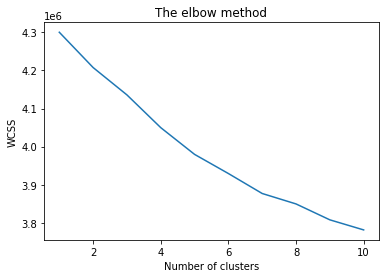

In [35]:
elbow_method(train_scaler)

**標準化なし**

In [36]:
df = train[B_feature2].copy()
df.head()

,f242,f243,f244,f245,f246,f247,f248,f249,f250,f251,...,f275,f276,f277,f278,f279,f280,f281,f282,f283,f284
0,1,0,1,1,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,1,0,0,0,1,0,0,1,0,1,...,1,0,1,0,0,0,0,0,0,0
2,0,0,1,1,1,1,0,0,1,0,...,0,0,0,0,1,1,0,0,0,0
3,1,0,1,1,1,1,0,1,1,0,...,1,0,0,0,0,1,0,0,0,0
4,0,0,1,1,0,0,0,1,1,1,...,0,0,1,1,0,1,0,0,1,0


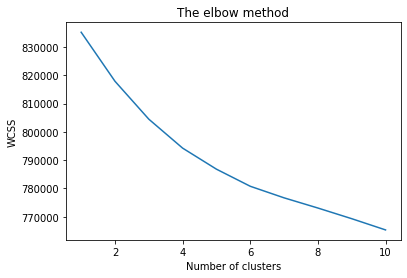

In [37]:
elbow_method(df)

In [ ]:
# from sklearn.cluster import KMeans
# def make_f_clustering(num_cluster, feature, data):
# #     feature = df_importance[:column_num].index#<-これを使ってクラスタリングで新しい特徴量を作る
    
#     df = data[feature]

#     #num_cluster=10 # cluster数

#     clusters = KMeans(n_clusters = num_cluster, random_state = 0, n_jobs = -1)
#     clusters.fit(df)
#     centers = clusters.cluster_centers_
#     columns = df.columns
#     clust_features = pd.DataFrame(index = df.index)
#     for i in range(len(centers)):
#         clust_features[str(num_cluster)+'_clust_dist_'+ str(i + 1)] = (df[columns] - centers[i]).applymap(abs).apply(sum, axis = 1)
#     return clust_features
#     #clust_features.head()
    

In [ ]:
# df_T = make_f_clustering( 3, B_feature2, train)
# df_t = make_f_clustering(3, B_feature2, test)

In [ ]:
# train = pd.concat([train.drop(columns = B_feature2), df_T],axis=1)
# test = pd.concat([test.drop(columns = B_feature2), df_t],axis=1)

In [ ]:
train.head()

# **Modeling**

### **Stacking Data Loader**

In [ ]:
def Stacking_Data_Loader(model, model_name, train, y, test, fold):
    '''
    Put your train, test datasets and fold value!
    This function returns train, test datasets for stacking ensemble :)
    '''

    stk = StratifiedKFold(n_splits = fold, random_state = 42, shuffle = True)
    
    # Declaration Pred Datasets
    train_fold_pred = np.zeros((train.shape[0], 1))
    test_pred = np.zeros((test.shape[0], fold))
    
    for counter, (train_index, valid_index) in enumerate(stk.split(train, y)):
        x_train, y_train = train.iloc[train_index], y[train_index]
        x_valid, y_valid = train.iloc[valid_index], y[valid_index]

        print('------------ Fold', counter+1, 'Start! ------------')
        if model_name == 'cat':
            model.fit(x_train, y_train, eval_set=[(x_valid, y_valid)])
        elif model_name == 'xgb':
            model.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], eval_metric = 'auc', verbose = 500, early_stopping_rounds = 200)
        else:
            model.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], eval_metric = 'auc', verbose = 500, early_stopping_rounds = 200)
            
        print('------------ Fold', counter+1, 'Done! ------------')
        
        train_fold_pred[valid_index, :] = model.predict_proba(x_valid)[:, 1].reshape(-1, 1)
        test_pred[:, counter] = model.predict_proba(test)[:, 1]
        
        del x_train, y_train, x_valid, y_valid
        gc.collect()
        
    test_pred_mean = np.mean(test_pred, axis = 1).reshape(-1, 1)
    
    del test_pred
    gc.collect()
    
    print('Done!')
    
    return train_fold_pred, test_pred_mean

### **Modeling**

#### Model's HyperParameters
* LGBM Param : https://www.kaggle.com/hiro5299834/tps-oct-2021-single-lightgbm
* Cat Param : https://www.kaggle.com/ranjeetshrivastav/tps-oct-21-catboost
* xgb Param : https://www.kaggle.com/rahulchauhan3j/tps-oct-2021-xgboost-pipeline-with-optuna#Model-Fit-and-Submission

Thanks for Sharing!

In [ ]:
lgb_params = {
    'objective': 'binary',
    'n_estimators': 20000,
    'random_state': 42,
    'learning_rate': 8e-3,
    'subsample': 0.6,
    'subsample_freq': 1,
    'colsample_bytree': 0.4,
    'reg_alpha': 10.0,
    'reg_lambda': 1e-1,
    'min_child_weight': 256,
    'min_child_samples': 20,
#     'device': 'cpu',
    'device': 'gpu',
}


xgb_params = {'n_estimators': 10000,
               'learning_rate': 0.03689407512484644,
               'max_depth': 8,
               'colsample_bytree': 0.3723914688159835,
               'subsample': 0.780714581166012,
               'eval_metric': 'auc',
               'use_label_encoder': False,
               'gamma': 0,
               'reg_lambda': 50.0,
#                'tree_method': 'hist',
                'tree_method': 'gpu_hist',
               'gpu_id': 0,
#                'predictor': 'cpu_predictor',
                'predictor': 'gpu_predictor',
               'random_state': 42}

cat_params = {'iterations': 17298,
               'learning_rate': 0.03429054860458741,
               'reg_lambda': 0.3242286463210283,
               'subsample': 0.9433911589913944,
               'random_strength': 22.4849972385133,
               'depth': 8,
               'min_data_in_leaf': 4,
               'leaf_estimation_iterations': 8,
               'task_type':"GPU",
               'bootstrap_type':'Poisson',
               'verbose' : 500,
               'early_stopping_rounds' : 200,
               'eval_metric' : 'AUC'}

In [ ]:
lgbm = LGBMClassifier(**lgb_params)

xgb = XGBClassifier(**xgb_params)

cat = CatBoostClassifier(**cat_params)

### **Stacking**

* Making train, test prediction array!
* Concat 3 arrays in 1 dataset

In [ ]:
cat_train, cat_test = Stacking_Data_Loader(cat, 'cat', train, y, test, 5)
del cat
gc.collect()

lgbm_train, lgbm_test = Stacking_Data_Loader(lgbm, 'lgbm', train, y, test, 5)
del lgbm
gc.collect()

xgb_train, xgb_test = Stacking_Data_Loader(xgb, 'xgb', train, y, test, 5)
del xgb
gc.collect()

### **Final Stacking Datasets!**

In [ ]:
stack_x_train = np.concatenate((cat_train, lgbm_train, xgb_train), axis = 1)
stack_x_test = np.concatenate((cat_test, lgbm_test, xgb_test), axis = 1)
# stack_x_train = np.concatenate((lgbm_train, xgb_train), axis = 1)
# stack_x_test = np.concatenate(( lgbm_test, xgb_test), axis = 1)
del cat_train, lgbm_train, xgb_train, cat_test, lgbm_test, xgb_test
gc.collect()

stack_x_train

In [ ]:
stack_x_train.shape

### **Save stack_x_train**

In [ ]:
cols = ['cat3_fc1','lgbm3_fc1', 'xgb3_fc1']
df_stack = pd.DataFrame(stack_x_train,columns = cols)
df_stack.to_csv('stacking_train_clx3_fc1.csv', index = 0)
df_stack.head()

In [ ]:
df_test = pd.DataFrame(stack_x_test,columns = cols)
df_test.to_csv('stacking_test_clx3_fc1.csv', index = 0)
df_test.head()

## Level 2 Training

In [ ]:
# stk = StratifiedKFold(n_splits = 5)

# test_pred_lo = 0
# fold = 1
# total_auc = 0

# for train_index, valid_index in stk.split(stack_x_train, y):
#     x_train, y_train = stack_x_train[train_index], y[train_index]
#     x_valid, y_valid = stack_x_train[valid_index], y[valid_index]
    
#     lr = LogisticRegression(n_jobs = -1, random_state = 42, C = 5, max_iter = 2000)
#     lr.fit(x_train, y_train)
    
#     valid_pred_lo = lr.predict_proba(x_valid)[:, 1]
#     test_pred_lo += lr.predict_proba(stack_x_test)[:, 1]
#     auc = roc_auc_score(y_valid, valid_pred_lo)
#     total_auc += auc / 5
#     print('Fold', fold, 'AUC :', auc)
#     fold += 1
    
# print('Total AUC score :', total_auc)

# **Submission!**

## Blending Level 2 results

In [ ]:
# sub = pd.read_csv('../input/tabular-playground-series-oct-2021/sample_submission.csv')
# sub['target'] = test_pred_lo
# sub.to_csv('sub.csv', index = 0)
# sub.head()

# Done!


## If you think this notebook is helpful for you, Please do not forget upvote!